# VGG16

In [ ]:
# This is the initial draft before ensembling, the main code can't be shared because of privacy purpose.

import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os
import pandas as pd

from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop

train_dir = "C:/Users/CVIS-3869/Desktop/Muntaha/Thesis/data/train"
test_dir = "C:/Users/CVIS-3869/Desktop/Muntaha/Thesis/data/test"
val_dir = "C:/Users/CVIS-3869/Desktop/Muntaha/Thesis/data/validation"

model = VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
input_shape = (224, 224)


In [ ]:
def plotGraph(h):
    pd.DataFrame(h.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    return plt.show()


In [ ]:
datagen_train = ImageDataGenerator(rescale=1./255)
datagen_test = ImageDataGenerator(rescale=1./255)
datagen_val = ImageDataGenerator(rescale=1./255)

batch_size = 16

generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

generator_val = datagen_val.flow_from_directory(directory=val_dir,
                                                target_size=input_shape,
                                                batch_size=batch_size,
                                                shuffle=False)

steps_test = generator_test.n / batch_size


transfer_layer = model.get_layer('block5_pool')
conv_model = Model(inputs=model.input, outputs=transfer_layer.output)


# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
# new_model.add(Dropout(0.5))

new_model.add(Dense(512, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
#new_model.add(Dense(512, activation='relu'))


# Add the final layer for the actual classification.
new_model.add(Dense(2, activation='softmax'))

optimizer = Adam(lr=1e-5)
loss = 'categorical_crossentropy'
metrics = ['categorical_accuracy']


def print_layer_trainable():
    for layer in conv_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))


print_layer_trainable()

new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

epochs = 40

steps_per_epoch = (generator_train.n/batch_size)/3

steps_val = generator_val.n/batch_size

history_vgg16 = new_model.fit_generator(generator=generator_train,
                                        epochs=epochs,
                                        steps_per_epoch=steps_per_epoch,
                                        validation_data=generator_val,
                                        validation_steps=steps_val)


Found 9665 images belonging to 2 classes.
Found 2769 images belonging to 2 classes.
Found 1374 images belonging to 2 classes.
True:	input_4
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


C:\Users\CVIS-3869\.conda\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
C:\Users\CVIS-3869\.conda\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
201/201 [==============================] - 142s 539ms/step - loss: 0.1874 - categorical_accuracy: 0.9235 - val_loss: 0.1598 - val_categorical_accuracy: 0.9360
Epoch 2/40
201/201 [==============================] - 99s 489ms/step - loss: 0.0753 - categorical_accuracy: 0.9751 - val_loss: 0.0992 - val_categorical_accuracy: 0.9622
Epoch 3/40
201/201 [==============================] - 98s 485ms/step - loss: 0.0568 - categorical_accuracy: 0.9807 - val_loss: 0.0955 - val_categorical_accuracy: 0.9614
Epoch 4/40
201/201 [==============================] - 98s 486ms/step - loss: 0.0364 - categorical_accuracy: 0.9867 - val_loss: 0.0821 - val_categorical_accuracy: 0.9658
Epoch 5/40
201/201 [==============================] - 98s 485ms/step - loss: 0.0309 - categorical_accuracy: 0.9907 - val_loss: 0.1593 - val_categorical_accuracy: 0.9374
Epoch 6/40
201/201 [==============================] - 98s 487ms/step - loss: 0.0365 - categorical_accuracy: 0.9879 - val_loss: 0.0856 - val_categorical_ac

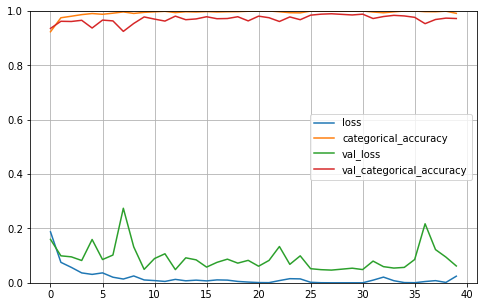

In [ ]:
plotGraph(history_vgg16)


# ResNet50

In [ ]:
from tensorflow.python.keras.applications.resnet import ResNet50
from tensorflow.python.keras.applications.resnet import preprocess_input, decode_predictions


In [ ]:
def trainableLayers(model):
    for i in range(len(list(model.layers))):
        print(list(model.layers)[i].name)
    return list(model.layers)[-1].name


In [ ]:
model4 = ResNet50(include_top=False, input_shape=(
    224, 224, 3), weights="imagenet")
l4 = trainableLayers(model4)
print("Last Layer : " + l4)


input_5
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [ ]:
def transferLayer(model, layer):
    conv_model = Model(inputs=model.input, outputs=layer.output)
    # Start a new Keras Sequential model
    new_model = Sequential()

    # Add the convolutional part of the model from above
    new_model.add(conv_model)

    # Flatten the output of the model because it is from a convolutional layer
    new_model.add(Flatten())

    # Add a dense (aka. fully-connected) layer
    # This is for combining features that the model has recognized in the image
    new_model.add(Dropout(0.5))

    new_model.add(Dense(512, activation="relu"))

    # Add the final layer for the actual classification
    new_model.add(Dense(2, activation="softmax"))

    return new_model


In [ ]:
layer4 = model4.get_layer(l4)
r50 = transferLayer(model4, layer4)


In [ ]:
r50.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               51380736  
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1026      
Total params: 74,969,474
Trainable params: 74,916,354
Non-trainable params: 53,120
_________________________________________________________________


C:\Users\CVIS-3869\.conda\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
201/201 [==============================] - 100s 497ms/step - loss: 0.0029 - categorical_accuracy: 0.9991 - val_loss: 0.0635 - val_categorical_accuracy: 0.9774
Epoch 2/40
201/201 [==============================] - 101s 499ms/step - loss: 4.6609e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0632 - val_categorical_accuracy: 0.9774
Epoch 3/40
201/201 [==============================] - 99s 490ms/step - loss: 3.7330e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0705 - val_categorical_accuracy: 0.9789
Epoch 4/40
201/201 [==============================] - 98s 486ms/step - loss: 9.9759e-05 - categorical_accuracy: 1.0000 - val_loss: 0.0760 - val_categorical_accuracy: 0.9767
Epoch 5/40
201/201 [==============================] - 98s 484ms/step - loss: 9.0162e-05 - categorical_accuracy: 1.0000 - val_loss: 0.0693 - val_categorical_accuracy: 0.9782
Epoch 6/40
201/201 [==============================] - 98s 489ms/step - loss: 3.0582e-05 - categorical_accuracy: 1.0000 - val_loss: 0.0727

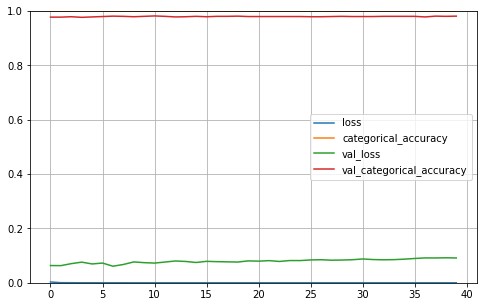

In [ ]:
# For cross-validation
history_resnet50 = r50.fit_generator(generator=generator_train,
                                     epochs=epochs,
                                     steps_per_epoch=steps_per_epoch,
                                     validation_data=generator_val,
                                     validation_steps=steps_val)
plotGraph(history_resnet50)


# Inception V3

In [ ]:
from tensorflow.python.keras.applications.inception_v3 import InceptionV3
from tensorflow.python.keras.applications.inception_v3 import preprocess_input, decode_predictions


In [ ]:
model3 = InceptionV3(include_top=False, input_shape=(
    224, 224, 3), weights="imagenet")
l3 = trainableLayers(model3)
print("Last Layer : " + l3)


input_6
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
max_pooling2d
conv2d_3
batch_normalization_3
activation_3
conv2d_4
batch_normalization_4
activation_4
max_pooling2d_1
conv2d_8
batch_normalization_8
activation_8
conv2d_6
conv2d_9
batch_normalization_6
batch_normalization_9
activation_6
activation_9
average_pooling2d
conv2d_5
conv2d_7
conv2d_10
conv2d_11
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
activation_5
activation_7
activation_10
activation_11
mixed0
conv2d_15
batch_normalization_15
activation_15
conv2d_13
conv2d_16
batch_normalization_13
batch_normalization_16
activation_13
activation_16
average_pooling2d_1
conv2d_12
conv2d_14
conv2d_17
conv2d_18
batch_normalization_12
batch_normalization_14
batch_normalization_17
batch_normalization_18
activation_12
activation_14
activation_17
activation_18
mixed1
conv2d_22
batch_normalization_22
activation_22
conv2d

In [ ]:
layer3 = model3.get_layer(l3)
iv3 = transferLayer(model3, layer3)
iv3.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Functional)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 51200)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1026      
Total params: 48,018,722
Trainable params: 47,984,290
Non-trainable params: 34,432
_________________________________________________________________


C:\Users\CVIS-3869\.conda\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
201/201 [==============================] - 98s 488ms/step - loss: 3.7193e-07 - categorical_accuracy: 1.0000 - val_loss: 0.0981 - val_categorical_accuracy: 0.9782
Epoch 2/40
201/201 [==============================] - 98s 487ms/step - loss: 3.9978e-07 - categorical_accuracy: 1.0000 - val_loss: 0.0992 - val_categorical_accuracy: 0.9782
Epoch 3/40
201/201 [==============================] - 98s 487ms/step - loss: 3.4696e-07 - categorical_accuracy: 1.0000 - val_loss: 0.0948 - val_categorical_accuracy: 0.9803
Epoch 4/40
201/201 [==============================] - 99s 491ms/step - loss: 2.9559e-07 - categorical_accuracy: 1.0000 - val_loss: 0.0954 - val_categorical_accuracy: 0.9803
Epoch 5/40
201/201 [==============================] - 99s 493ms/step - loss: 2.4194e-07 - categorical_accuracy: 1.0000 - val_loss: 0.0951 - val_categorical_accuracy: 0.9803
Epoch 6/40
201/201 [==============================] - 98s 489ms/step - loss: 2.0551e-07 - categorical_accuracy: 1.0000 - val_loss: 0.09

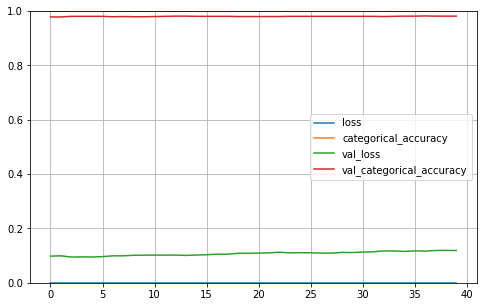

In [ ]:
# For cross-validation
history_inceptionv3 = iv3.fit_generator(generator=generator_train,
                                        epochs=epochs,
                                        steps_per_epoch=steps_per_epoch,
                                        validation_data=generator_val,
                                        validation_steps=steps_val)
plotGraph(history_inceptionv3)


In [ ]:
ens_input = Input(shape=(224, 224, 3))
ens_models = [new_model(ens_input), r50(ens_input), iv3(ens_input)]
ens_outputs = layers.average(ens_models)
ensemble_model = keras.Model(inputs=ens_input, outputs=ens_outputs)
history_ens = new_model.fit_generator(generator=generator_train,
                                      epochs=epochs,
                                      steps_per_epoch=steps_per_epoch,
                                      validation_data=generator_val,
                                      validation_steps=steps_val)
plotGraph(history_ens)


TypeError: 'module' object is not callable